# Pneumonia detection

        TODO: ADD More info...

Imports

In [2]:
'''
    Run this in case the following imports don't run.
    !pip install torch==1.4.0+cu100 torchvision==0.5.0+cu100 -f https://download.pytorch.org/whl/torch_stable.html
'''
# import time
# import copy
import os
# import cv2

# import numpy as np
# import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
# from random import shuffle
# from mlxtend.plotting import plot_confusion_matrix

# import torch
# import torch.nn as nn
# import torch.nn.functional as F 

# from torch import nn, optim
from torch import optim
# from torch.nn.modules.loss import BCEWithLogitsLoss
# from torch.utils.data import ConcatDataset, DataLoader
from torch.utils.data import DataLoader

# from torchvision import models # TODO: Will this really work?
# from torchvision import transforms as transforms, datasets, models
from torchvision import transforms, datasets
# from torchvision.utils import make_grid
# from torchvision.models.utils import load_state_dict_from_url

# import sklearn
# from sklearn.metrics import accuracy_score, cohen_kappa_score, classification_report, confusion_matrix
# from sklearn.model_selection import train_test_split

# ? torchvision
# ? transforms
# ? datasets
# ? models

"\n    Run this in case the following imports don't run.\n    !pip install torch==1.4.0+cu100 torchvision==0.5.0+cu100 -f https://download.pytorch.org/whl/torch_stable.html\n"

Parameters

In [ ]:

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyper Parameters
epochs = 4
w_decay = 1e-3
momentum = 0.9
batch_size = 32
learn_rate = 0.001

## Prepare data

#### Colab only...

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Data augmentation

In [ ]:
'''
    TODO: 2022-06-22 - What mean all these parameter values?
'''

# Train: Transform sequence 01
transf_train = transforms.Compose([
    transforms.Resize(60),
    transforms.RandomCrop(54),
    transforms.ToTensor(), # Converts pixels [0-255] to tensors [0-1] TODO: Understand it
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

# Train: Transform sequence 02
transf_train2 = transforms.Compose([
    transforms.Resize(57),
    transforms.RandomRotation(10),
    transforms.RandomCrop(54),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# creates the transforms sequence for the test and val sets
# Test & Validation: Transform sequence
transf_test = transforms.Compose([
    transforms.Resize(54),
    transforms.CenterCrop(54),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

### Load dataset

In [4]:
dir_data = "/content/drive/MyDrive/data_pneumonia/chest_xray/chest_xray"
dir_val = os.path.join(dir_data, 'val')
dir_test =  os.path.join(dir_data', test')
dir_train =  os.path.join(dir_data, 'train')
dir_train_normal = os.join(dir_train, 'NORMAl')
dir_train_pneumonia = os.join(dir_train, 'PNEUMONIA')

'''
    TODO: 2022-06-22 - Figure balancing out
    # criando 2 sets de treinamento para mesclar os dois e balancear as classes
'''

# Datasets
ds_train1 = datasets.ImageFolder(dir_train, transform=transf_train)
# ds_train2 = datasets.ImageFolder(dir_train, transform=transf_train2)
ds_test = datasets.ImageFolder(dir_test, transform=transf_test)
ds_validation = datasets.ImageFolder(dir_val, transform=transf_test)

# Data loaders
loader_train = DataLoader(ds_train1, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(ds_validation, batch_size=batch_size, shuffle=True)
loader_valid = DataLoader(ds_test, batch_size=batch_size, shuffle=True)

# Create new validation set TODO: Figure this out!
# trainset, validset = train_test_split(trainset, test_size=0.2)

# See what we've done
n_train = len(ds_train1)
n_test = len(ds_train)
n_validation = len(ds_validation)

class_names = ds_train1.classes
images, labels = iter(loader_train).next()

print('Train: {} images, Test: {} images, Validation: {} images'.format(n_train, n_test, n_validation))
print('Classes: ' + str(trainset.class_to_idx))
print('Images shape: {}'.format(str(images.shape))) # torch.Size([32, 3, 54, 54])
print('Labels shape: {}'.format(str(labels.shape))) # torch.Size([32])


hey {'foo': 'bar', 'baz': 'jow'}


### Data Balancing
    > TODO...

#### See data: Unbalanced Distribution

In [ ]:
files_normal = [os.path.join(dir_train_normal, file) for file in os.listdir(dir_train_normal)]
files_pneumonia = [os.path.join(dir_train_pneumonia, file) for file in os.listdir(dir_train_pneumonia)]
df_train_unbalanced = pd.DataFrame.from_dict({ 'Normal': [len(files_normal)], 'Pneumonia': [len(files_pneumonia)] })

sns.barplot(data=df_train_unbalanced).set_title('Training Data: Unbalanced', fontsize=20)
plt.show()

#### Run Balancing

TODO: 2022-06-22 - Figure this out!

In [ ]:
#balanceando as classes
#trainset2, _ = train_test_split(trainset2, test_size= 3875/train_size, shuffle=False)
#trainset = ConcatDataset([trainset, trainset2])

### See our images

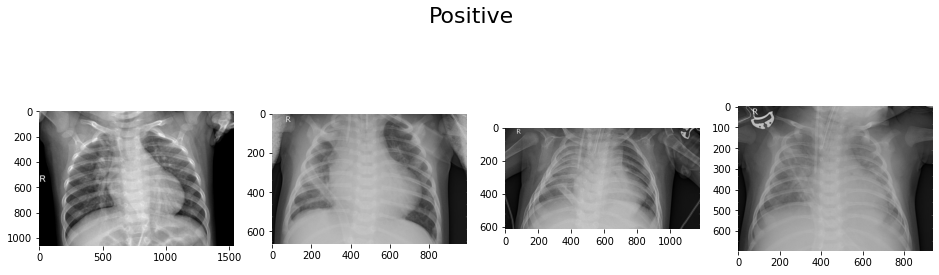

In [19]:
fig = plt.figure(figsize=(16, 5))
fig.suptitle("Positive", size=22)
img_paths = os.listdir("/content/drive/MyDrive/data_pneumonia/chest_xray/chest_xray/train/PNEUMONIA")

shuffle(img_paths)
for i, image in enumerate(img_paths[:4]):
    img_path = os.path.join("/content/drive/MyDrive/data_pneumonia/chest_xray/chest_xray/train/PNEUMONIA", image)
    img = cv2.imread(img_path)
    plt.subplot(1, 4, i + 1, frameon=False)
    plt.imshow(img)
fig.show()

## Build Model


### Model backbone: resnet18, pretrained

- Backbone (feature extractor): Resnet
- We use pre-trained weights of Resnet (from torch.models) to increase accuracy & reduce training time.


In [ ]:

'''
	NOTE: We need to replace the original last layer
	- Last layer is a linear fully connected one with many outputs;
	- Our net needs 02 (as we have 02 classes);
	- We replace it so it becomes a binary classifier;
	- We end up with a new last layer holding the same number of inputs but only 02 outputs:
	
	NOTE: The end network has no activation function
	- For our binary classification we'd need a sigmoid activation;
	- But we skip this job as our cost function already handles this; TODO: Figure this out!
'''

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2) # Replace last layer
for params in model.parameters():	# Freeze parameters (so pre-trained convolution layers don't change)
	params.requires_grad_ = False

model = model.to(DEVICE)
criterion = nn.CrossEntropyLoss() # Loss function
optimizer = optim.Adam(model.parameters(), lr=learn_rate)

print(model)

## Training

#### Trainer

In [37]:
'''
    TODO: 2022-06-23 - ADD accuracy history to the return
'''

def train(
    model: nn.Module, optimizer: optim.Optimizer, criterion: nn.CrossEntropyLoss,
    loader_train: DataLoader, loader_val: DataLoader,
    n_epochs: int,
) -> None:
    
    since = time.time()
    best_model = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    n_train = len(loader_train)
    n_validation = len(loader_val)
    
    for epoch in range(n_epochs):
        print('Epoch {}/{}'.format(epoch + 1, n_epochs))
        
        # Train
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in tqdm(loader_train, total=n_train):
            
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, y_hat = torch.max(outputs, 1)

                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

            running_loss += loss.item() * inputs.size(0) # TODO: Figure this out
            running_corrects += torch.sum(y_hat == labels.data)
            
        epoch_loss = running_loss / n_train
        epoch_accuracy = running_corrects.double() / n_train
        print('Train Loss: {:.4f}; Train Acc: {:.4f}'.format(epoch_loss, epoch_accuracy))
        
        # Validate
        model.eval()
        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in loader_val:
            
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            optimizer.zero_grad()
            
            with torch.set_grad_enabled(False):
                outputs = model(inputs)
                _, y_hat = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                
            running_loss += loss.item() * inputs.size(0) # TODO: Figure this out
            running_corrects += torch.sum(y_hat == labels.data)

        epoch_loss = running_loss / n_validation
        epoch_accuracy = running_corrects.double() / n_validation
        print('Val Loss: {:.4f}; Val Acc: {:.4f}'.format(epoch_loss, epoch_accuracy))
        print('-' * 30)
        
        if epoch_accuracy > best_acc:
            best_acc = epoch_accuracy
            best_model = copy.deepcopy(model.state_dict())
        
    model.load_state_dict(best_model)
    time_elapsed = time.time() - since
    
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Val Acc: {:.4f}'.format(best_acc))
    return model

### Train

In [40]:
model = train_model(model, criterion, optimizer, epochs)

Epoch 1/4


100%|██████████| 163/163 [01:34<00:00,  1.72it/s]


Train Loss: 0.0597 Train Acc: 0.9781
Val Loss: 0.3527 Val Acc: 0.8750
------------------------------
Epoch 2/4


100%|██████████| 163/163 [01:33<00:00,  1.74it/s]


Train Loss: 0.0564 Train Acc: 0.9797
Val Loss: 0.4870 Val Acc: 0.8125
------------------------------
Epoch 3/4


100%|██████████| 163/163 [01:32<00:00,  1.77it/s]


Train Loss: 0.0542 Train Acc: 0.9781
Val Loss: 0.4075 Val Acc: 0.9375
------------------------------
Epoch 4/4


100%|██████████| 163/163 [01:32<00:00,  1.76it/s]


Train Loss: 0.0519 Train Acc: 0.9812
Val Loss: 0.2981 Val Acc: 0.9375
------------------------------
Training complete in 6m 14s
Best Val Acc: 0.9375


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [43]:
model_save_name = 'classifier.pt'
path = F"/content/drive/MyDrive/{model_save_name}" 
torch.save(model.state_dict(), path)

## Testing
Test set accuracy and performance

In [47]:
def visualize_predictions(model, dataset):
    labels = []
    predictions = []
    acc = 0
    was_training = model.training
    model.eval()
    with torch.no_grad():
        for i in range(len(dataset)):
            input, label = dataset[i]
            input = input[np.newaxis,:]
            input = input.to(DEVICE)
            output = model(input)
            _, preds = torch.max(output, 1)
            if class_names[label] == class_names[preds]:
                acc += 1
            labels.append(class_names[label])
            predictions.append(class_names[preds])
    print('Test Accuracy: {:.4f}'.format(acc/len(dataset)))
    model.train(mode=was_training)
    return labels, predictions

In [48]:
# predicting the test set
labels, predictions = visualize_predictions(model, testset)

Test Accuracy: 0.9215


<Figure size 432x288 with 0 Axes>

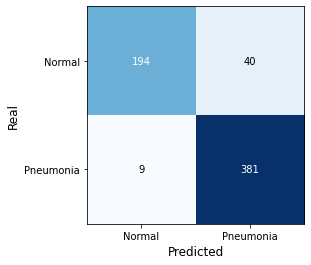

In [52]:
# confusion matrix
matrix = confusion_matrix(labels, predictions)
plt.figure()
plot_confusion_matrix(matrix, figsize=(4,4))
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=10)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=10)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Real', fontsize=12)
plt.show()